In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

!curl -O https://lazyprogrammer.me/course_files/airline_passengers.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2036  100  2036    0     0   2546      0 --:--:-- --:--:-- --:--:--  2548


In [2]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
df['LogPassengers'] = np.log(df['Passengers'])
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

Make dataset

In [4]:
series = df['LogPassengers'].to_numpy()
T = 10
X = [series[t:t+T] for t in range(len(series) - T)]
Y = [series[t+T] for t in range(len(series) - T)]

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
X.shape, Y.shape

((134, 10), (134,))

In [5]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [6]:
lr_model = LinearRegression()
lr_model.fit(Xtrain, Ytrain)
lr_model.score(Xtrain, Ytrain)

0.9599443783339897

In [7]:
lr_model.score(Xtest, Ytest)

0.6910953044565575

In [9]:
# Indexing
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx
train_idx[:T] = False # First T values unpredictable

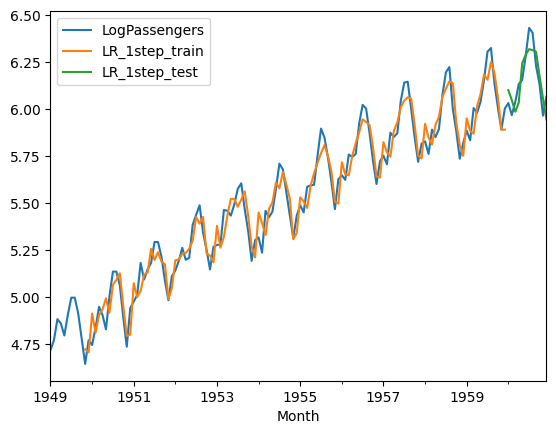

In [11]:
df.loc[train_idx, 'LR_1step_train'] = lr_model.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr_model.predict(Xtest)
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot();

In [17]:
Xtest[0].reshape(1, -1).shape

(1, 10)

In [15]:
# Multi-step forecast
multistep_preds = []
last_x = Xtest[0]

while len(multistep_preds) < Ntest:
    p = lr_model.predict(last_x.reshape(1, -1))[0]
    
    # update prediction list
    multistep_preds.append(p)
    
    # make new input
    # e.g. Existing = [1, 2, 3, 4, 5], p = 6
    # After rolling: [2, 3, 4, 5, 1]
    # Replace last element with prediction: [2, 3, 4, 5, 6]
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [18]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_preds

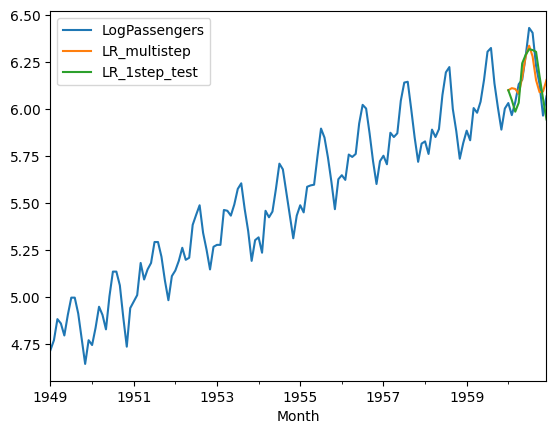

In [19]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot();

Make multi-output supervised dataset:

Use T previous values to forecast future Ntest values.

In [21]:
Tx = T
Ty = Ntest
X = [series[t:t+Tx] for t in range(len(series) - Tx - Ty + 1)]
Y = [series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty + 1)]

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [22]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.9734607773512528

In [23]:
len(Xtest_m), len(Ytest_m)

(1, 1)

Since we only have one test data, we can't directly call `lr.score`

In [24]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.801874967671522

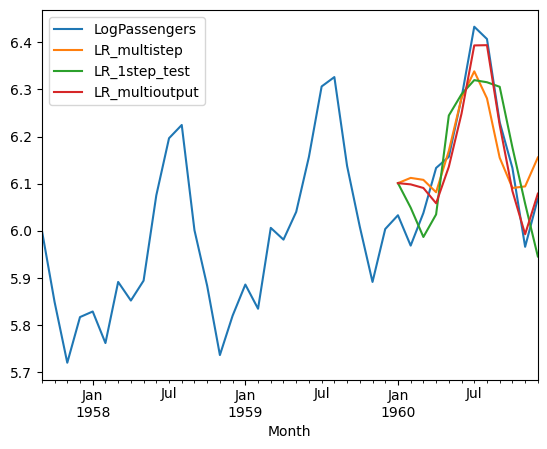

In [26]:
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df.iloc[-40:][cols].plot();

In [27]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_preds)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.012229325023475209
multi-output MAPE: 0.007178924475039767


### Test other models

In [36]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)
    
    df.loc[train_idx, f"{name}_1step_train"] = model.predict(Xtrain)
    df.loc[test_idx, f"{name}_1step_test"] = model.predict(Xtest)
    
    multistep_preds = []
    last_x = Xtest[0]
    
    while len(multistep_preds) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]
        multistep_preds.append(p)
        last_x = np.roll(last_x, -1)
        last_x[-1] = p
        
    df.loc[test_idx, f"{name}_multistep_test"] = multistep_preds
    mape = mean_absolute_percentage_error(Ytest, multistep_preds)
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test'
    ]
    df.iloc[-40:][cols].plot();

One-step forecast: SVR
Test MAPE (multi-step): 0.017529446164230467


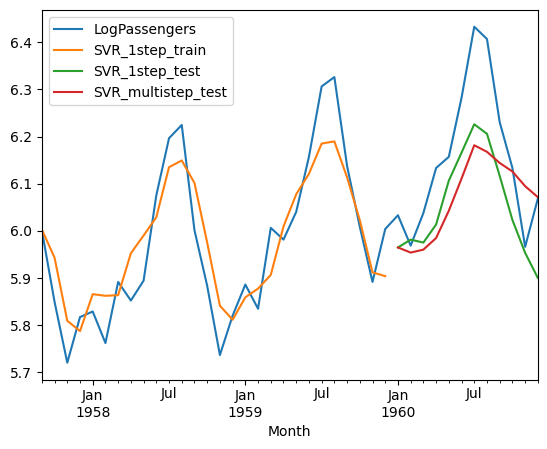

In [37]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.029009655402304806


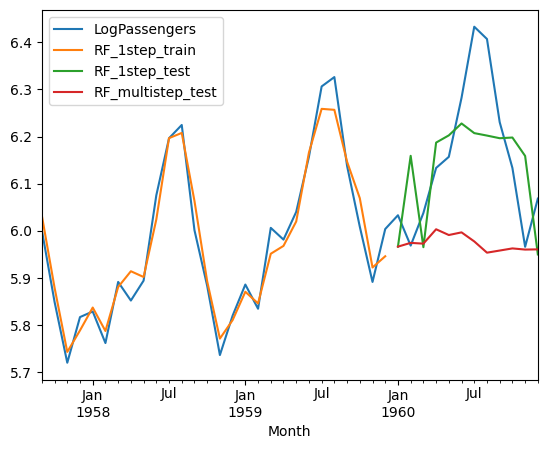

In [38]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [39]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)
    df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()
    
    mape = mean_absolute_percentage_error(
        Ytest, df.loc[test_idx, f'{name}_multioutput']
    )
    print("Test MAPE (multi-output):", mape)

    cols = [
        'LogPassengers',
        f'{name}_1step_train',
        f'{name}_1step_test',
        f'{name}_multistep_test',
        f'{name}_multioutput',
    ]
    df[cols].plot();

Test MAPE (multi-output): 0.016910122543928614


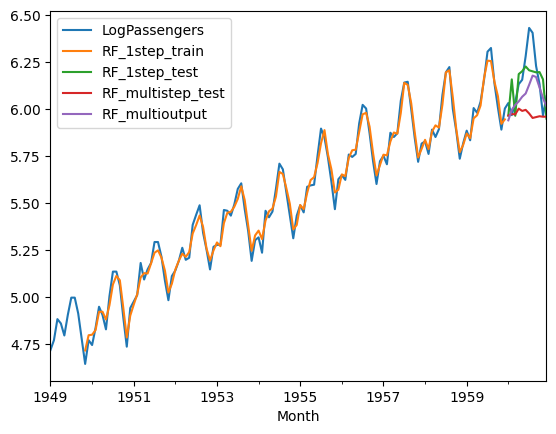

In [40]:
# Note: SVR can't handle multi-output forecasting
multi_output_forecast(RandomForestRegressor(), "RF")